# UNETを利用した, 水路のセマンティックセグメンテーション

## 概要
このコードでは, Oyoneによって収集された水路画像から作成された水路データセットを用いてセマンティックセグメンテーションを行う。

参考https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch/notebook

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from torchinfo import summary

from PIL import Image
import cv2
import albumentations as A  # Data Augmentation

import time
import os 
import json
from tqdm import tqdm

import segmentation_models_pytorch as smp  # Segmentationのモデル

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 前処理

In [61]:
IMAGE_PATH = '../processed_data/voc_datasets/iriomote_train_voc/JPEGImages/'
MASK_PATH = '../processed_data/voc_datasets/iriomote_train_voc/SegmentationClassPNG/'
SAVE_MODEL_DIR = '../trained_models'

# Saving Json file
SAVE_JSON_DIR = "../records/"
JSON_PATH = os.path.join(SAVE_JSON_DIR,"iriomote_train_voc.json")

RANDOM_STATE = 42

In [62]:
def create_df(path):
    name = []
    for dir_name, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index=np.arange(0, len(name)))

df = create_df(IMAGE_PATH)
print('Total Images: ', len(df))
# print('Total Test Images: ', len(df_test))
df = df.sort_values('id')
df = df.sample(frac=1, random_state=RANDOM_STATE)
df

Total Images:  1653


,id
717,converted_2022_8_26_18_35_00002920
547,converted_2022_8_26_18_35_00001395
125,converted_2022_8_26_18_39_00005090
405,converted_2022_8_26_18_39_00004160
200,converted_2022_8_26_18_35_00001095
...,...
851,converted_2022_9_9_16_44_00000335
504,converted_2022_9_9_16_44_00001355
544,converted_2022_9_9_16_33_00001390
1555,converted_2022_9_9_16_44_00002395


In [63]:
TRAIN_RATE = 0.8
VAL_RATE = 0.2

train_num = int(TRAIN_RATE*len(df))
val_num = int(VAL_RATE*len(df))

df_train = df[0:train_num]
df_val = df[train_num:]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
# print('Test size: ', len(df_test))
df_train

Train size:  1322
Val size:  331


,id
0,converted_2022_8_26_18_35_00002920
1,converted_2022_8_26_18_35_00001395
2,converted_2022_8_26_18_39_00005090
3,converted_2022_8_26_18_39_00004160
4,converted_2022_8_26_18_35_00001095
...,...
1317,converted_2022_9_9_16_44_00001615
1318,converted_2022_9_9_16_33_00002255
1319,converted_2022_9_9_16_44_00001980
1320,converted_2022_9_9_16_33_00001930


Image Size (480, 640, 3)
Mask Size (480, 640)


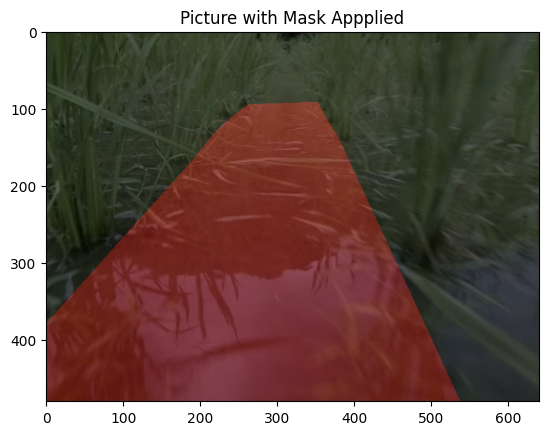

In [64]:
TEST_INDEX = 10
img = Image.open(IMAGE_PATH + df['id'][TEST_INDEX] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][TEST_INDEX] + '.png')

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

## Dataset

In [65]:
class WaterLaneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # load mask image as grey image
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)  # np.ndarray -> {'image': image, 'mask': mask}
            # convert ndarray to PIL.Image.Image to input torchvision.transforms
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            mask = mask == 38

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        # torch loss function for segmentation task only accept int64(long)
        mask = torch.from_numpy(mask).long()  

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def __checkimages__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            cvt_img = Image.fromarray(aug['image'])
            cvt_mask = aug['mask']

        if self.transform is None:
            cvt_img = Image.fromarray(img)
            cvt_mask = mask

        return img, cvt_img, mask, cvt_mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches


## Data Augmentation
* データ拡張ツールalbumentationsを使用する。\
参考リンク: https://github.com/albumentations-team/albumentations \

* numpyarrayをパイプラインに通して前処理を行う。

* 水路データに必要そうなData Augmentation
    * ランダムな切り取り
    * 明るさの変化
    * データの拡大

In [66]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# WIDTH = 480
# HEIGHT = 320
WIDTH = 224
HEIGHT = 224

# 学習データのDataAugmentation
t_train = A.Compose([A.Resize(HEIGHT, WIDTH),
A.RandomBrightnessContrast(brightness_limit=0.5, p=0.5),  #  画像の明るさの変化,
A.Rotate([-45, 45], p=0.5),
A.GaussNoise()
])

# 検証データのDataAugmentation
t_val = A.Compose([A.Resize(HEIGHT, WIDTH)])

train_set = WaterLaneDataset(IMAGE_PATH, MASK_PATH, df_train['id'], mean, std, t_train, patch=False)
val_set = WaterLaneDataset(IMAGE_PATH, MASK_PATH,df_val['id'], mean, std, t_val, patch=False)

batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [67]:
print(train_set.__getitem__(0)[1].shape)
print(train_set.__getitem__(0)[1].unique())

torch.Size([224, 224])
tensor([0, 1])


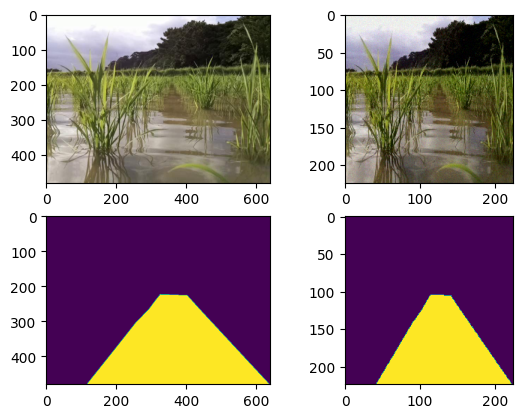

In [68]:
img, cvt_img, mask, cvt_mask = train_set.__checkimages__(2)
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
plt.imshow(img)

ax2 = fig.add_subplot(2, 2, 2)
plt.imshow(cvt_img)

ax3 = fig.add_subplot(2, 2, 3)
plt.imshow(mask)

ax4 = fig.add_subplot(2, 2, 4)
plt.imshow(cvt_mask)

plt.show()

## Model

In [69]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    'mobilenet_v2',
    encoder_weights='imagenet',
    classes=2, 
    activation=None,
    encoder_depth=5, 
    decoder_channels=[256, 128, 64, 32, 16]
    )
summary(model, input_size=(16, 3, HEIGHT, WIDTH))

Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [16, 2, 224, 224]         --
├─MobileNetV2Encoder: 1-1                               [16, 3, 224, 224]         --
│    └─Sequential: 2-1                                  --                        --
│    │    └─Conv2dNormActivation: 3-1                   [16, 32, 112, 112]        928
│    │    └─InvertedResidual: 3-2                       [16, 16, 112, 112]        896
│    │    └─InvertedResidual: 3-3                       [16, 24, 56, 56]          5,136
│    │    └─InvertedResidual: 3-4                       [16, 24, 56, 56]          8,832
│    │    └─InvertedResidual: 3-5                       [16, 32, 28, 28]          10,000
│    │    └─InvertedResidual: 3-6                       [16, 32, 28, 28]          14,848
│    │    └─InvertedResidual: 3-7                       [16, 32, 28, 28]          14,848
│    │    └─InvertedResidual: 3-8       

In [70]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [10]:
# コンパクト版モデル
model = smp.Unet(
    'mobilenet_v2',
    encoder_weights='imagenet',
    classes=2, 
    activation=None,
    encoder_depth=3, 
    decoder_channels=[64, 32, 16]
    )
summary(model, input_size=(16, 3, HEIGHT, WIDTH))

Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [16, 2, 224, 224]         --
├─MobileNetV2Encoder: 1-1                               [16, 3, 224, 224]         --
│    └─Sequential: 2-1                                  --                        2,168,384
│    │    └─Conv2dNormActivation: 3-1                   [16, 32, 112, 112]        928
│    │    └─InvertedResidual: 3-2                       [16, 16, 112, 112]        896
│    │    └─InvertedResidual: 3-3                       [16, 24, 56, 56]          5,136
│    │    └─InvertedResidual: 3-4                       [16, 24, 56, 56]          8,832
│    │    └─InvertedResidual: 3-5                       [16, 32, 28, 28]          10,000
│    │    └─InvertedResidual: 3-6                       [16, 32, 28, 28]          14,848
│    │    └─InvertedResidual: 3-7                       [16, 32, 28, 28]          14,848
├─UnetDecoder: 1-2               

## Training

In [71]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)  # 画素ごとの最大クラスを求める
        correct = torch.eq(output, mask).int()  # 予想ラベルがあってるところを1としたTensor
        accuracy = float(correct.sum()) / float(correct.numel())  # 全ピクセルの正答率
    return accuracy

In [72]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    """
    IoUの計算関数
    pred_mask: モデルが出力した画素ごとのクラスごとの確率
    mask: 正解mask(int64のtensor)
    """
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)  # (N, C, H, W)のCにsoftmax
        pred_mask = torch.argmax(pred_mask, dim=1)  # 画素ごとの最大クラスを取り出す
        pred_mask = pred_mask.contiguous().view(-1)  # maskを要素順にメモリに並べ(contiguous)1次元に(view)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):  # loop per pixel class
            # clas ラベルの部分を1としたマスクを作成
            true_class = pred_mask == clas  
            true_label = mask == clas

            # 正解画像中に指定クラスのピクセルが1つもなければ, iou=0とする
            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                # 0以外の画素をTrue, 0をFalseとしてandとorをとる
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        
        # nanを無視したIoUの平均値mIoUを返す
        return np.nanmean(iou_per_class)

In [73]:

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.Inf
    decrease = 1; not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        # training loop
        for i, data in enumerate(tqdm(train_loader)):
            # training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device)
            # forward
            output = model(image)
            # output: (N, C, H, W)Tensor, mask: (N, H, W)Tensor
            loss = criterion(output, mask)
            # evaluate metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            # backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # step ths learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:  # for ~ else 'for が終了するとelseブロックが動き出す'
            print('----- evaluation -----')
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            # validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device)
                    output = model(image)
                    # evaluation metrics
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    # loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            # 精度が向上した際の挙動、5回向上したらモデルの保存を行う
            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f}'.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model ...')
                    torch.save(model.state_dict(), '../trained_models/Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))

            # 精度が向上しなかったepochの挙動, 7回向上しなかったら、学習中止
            if (test_loss/len(val_loader) > min_loss):
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            # iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

100%|██████████| 166/166 [07:05<00:00,  2.56s/it]


----- evaluation -----


100%|██████████| 42/42 [00:25<00:00,  1.62it/s]


Loss Decreasing.. inf >> 0.178
Epoch:1/15.. Train Loss: 0.369.. Val Loss: 0.178.. Train mIoU:0.711.. Val mIoU: 0.862.. Train Acc:0.828.. Val Acc:0.927.. Time: 7.52m


100%|██████████| 166/166 [05:34<00:00,  2.02s/it]


----- evaluation -----


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Loss Decreasing.. 0.178 >> 0.166
Epoch:2/15.. Train Loss: 0.185.. Val Loss: 0.166.. Train mIoU:0.850.. Val mIoU: 0.854.. Train Acc:0.922.. Val Acc:0.922.. Time: 6.01m


100%|██████████| 166/166 [05:19<00:00,  1.93s/it]


----- evaluation -----


100%|██████████| 42/42 [00:24<00:00,  1.72it/s]


Loss Decreasing.. 0.166 >> 0.114
Epoch:3/15.. Train Loss: 0.164.. Val Loss: 0.114.. Train mIoU:0.875.. Val mIoU: 0.910.. Train Acc:0.935.. Val Acc:0.954.. Time: 5.74m


100%|██████████| 166/166 [05:14<00:00,  1.90s/it]


----- evaluation -----


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Loss Decreasing.. 0.114 >> 0.106
saving model ...
Epoch:4/15.. Train Loss: 0.136.. Val Loss: 0.106.. Train mIoU:0.893.. Val mIoU: 0.916.. Train Acc:0.945.. Val Acc:0.957.. Time: 5.69m


100%|██████████| 166/166 [05:35<00:00,  2.02s/it]


----- evaluation -----


100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Loss Decreasing.. 0.106 >> 0.098
Epoch:5/15.. Train Loss: 0.136.. Val Loss: 0.098.. Train mIoU:0.895.. Val mIoU: 0.921.. Train Acc:0.946.. Val Acc:0.960.. Time: 6.02m


100%|██████████| 166/166 [06:08<00:00,  2.22s/it]


----- evaluation -----


100%|██████████| 42/42 [00:27<00:00,  1.54it/s]


Loss Not Decrease for 1 time
Epoch:6/15.. Train Loss: 0.119.. Val Loss: 0.134.. Train mIoU:0.908.. Val mIoU: 0.907.. Train Acc:0.953.. Val Acc:0.952.. Time: 6.60m


100%|██████████| 166/166 [05:12<00:00,  1.88s/it]


----- evaluation -----


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Loss Decreasing.. 0.134 >> 0.087
Epoch:7/15.. Train Loss: 0.117.. Val Loss: 0.087.. Train mIoU:0.909.. Val mIoU: 0.932.. Train Acc:0.954.. Val Acc:0.966.. Time: 5.63m


100%|██████████| 166/166 [04:57<00:00,  1.79s/it]


----- evaluation -----


100%|██████████| 42/42 [00:31<00:00,  1.34it/s]


Loss Not Decrease for 2 time
Epoch:8/15.. Train Loss: 0.098.. Val Loss: 0.099.. Train mIoU:0.921.. Val mIoU: 0.923.. Train Acc:0.961.. Val Acc:0.961.. Time: 5.48m


100%|██████████| 166/166 [05:16<00:00,  1.91s/it]


----- evaluation -----


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Loss Decreasing.. 0.099 >> 0.080
Epoch:9/15.. Train Loss: 0.088.. Val Loss: 0.080.. Train mIoU:0.927.. Val mIoU: 0.936.. Train Acc:0.964.. Val Acc:0.968.. Time: 5.72m


100%|██████████| 166/166 [05:05<00:00,  1.84s/it]


----- evaluation -----


100%|██████████| 42/42 [00:24<00:00,  1.69it/s]


Loss Not Decrease for 3 time
Epoch:10/15.. Train Loss: 0.079.. Val Loss: 0.082.. Train mIoU:0.935.. Val mIoU: 0.933.. Train Acc:0.968.. Val Acc:0.967.. Time: 5.50m


100%|██████████| 166/166 [05:19<00:00,  1.92s/it]


----- evaluation -----


100%|██████████| 42/42 [00:23<00:00,  1.82it/s]


Loss Decreasing.. 0.082 >> 0.074
Epoch:11/15.. Train Loss: 0.074.. Val Loss: 0.074.. Train mIoU:0.938.. Val mIoU: 0.939.. Train Acc:0.969.. Val Acc:0.970.. Time: 5.71m


100%|██████████| 166/166 [05:19<00:00,  1.93s/it]


----- evaluation -----


100%|██████████| 42/42 [00:37<00:00,  1.12it/s]


Loss Not Decrease for 4 time
Epoch:12/15.. Train Loss: 0.067.. Val Loss: 0.074.. Train mIoU:0.944.. Val mIoU: 0.942.. Train Acc:0.972.. Val Acc:0.971.. Time: 5.96m


100%|██████████| 166/166 [04:35<00:00,  1.66s/it]


----- evaluation -----


100%|██████████| 42/42 [00:21<00:00,  1.93it/s]


Loss Decreasing.. 0.074 >> 0.072
saving model ...
Epoch:13/15.. Train Loss: 0.065.. Val Loss: 0.072.. Train mIoU:0.945.. Val mIoU: 0.942.. Train Acc:0.973.. Val Acc:0.971.. Time: 4.97m


100%|██████████| 166/166 [04:12<00:00,  1.52s/it]


----- evaluation -----


100%|██████████| 42/42 [00:21<00:00,  1.94it/s]


Loss Decreasing.. 0.072 >> 0.071
Epoch:14/15.. Train Loss: 0.062.. Val Loss: 0.071.. Train mIoU:0.948.. Val mIoU: 0.944.. Train Acc:0.974.. Val Acc:0.972.. Time: 4.56m


100%|██████████| 166/166 [03:58<00:00,  1.44s/it]


----- evaluation -----


100%|██████████| 42/42 [00:20<00:00,  2.01it/s]


Loss Not Decrease for 5 time
Epoch:15/15.. Train Loss: 0.060.. Val Loss: 0.071.. Train mIoU:0.949.. Val mIoU: 0.943.. Train Acc:0.975.. Val Acc:0.972.. Time: 4.32m
Total time: 85.43 m


In [30]:
# torch.save(model.state_dict(), '../trained_models/Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format())

In [16]:
with open(JSON_PATH, 'w') as fp:
    json.dump(history, fp)

In [19]:
with open('../records/iriomote_train_dataset/iriomote_train_voc.json', "r") as fp:
    loaded_history = json.load(fp)
loaded_history

{'train_loss': [0.3690229800630765,
  0.18542250012417874,
  0.16385809798915701,
  0.13600552562310034,
  0.13557009627840605,
  0.11861366549708757,
  0.11704873066979,
  0.09783463379794574,
  0.08847315503980022,
  0.07902036575847361,
  0.0741238422377641,
  0.06691378175494182,
  0.06489578603082392,
  0.0620713963072343,
  0.06048742883715285],
 'val_loss': [0.17768684632721402,
  0.16603148941482818,
  0.11392539987961452,
  0.10577059608130228,
  0.09751423501542636,
  0.13371761639912924,
  0.08706937535178094,
  0.09853939898312092,
  0.07997765622678257,
  0.08241239633588564,
  0.07356464614470799,
  0.07417768479457923,
  0.07215374353386107,
  0.0708818771832046,
  0.07125787011214665],
 'train_miou': [0.711481569171673,
  0.8501305185394109,
  0.8746564169202029,
  0.8927164970185134,
  0.8946357778932107,
  0.908175884117139,
  0.909092380211977,
  0.9214518448559776,
  0.9272408434644576,
  0.9349299446713293,
  0.938215839256391,
  0.9435329491449601,
  0.94548024335

In [74]:
def plot_loss(history, delete_title=False, delete_grid=False):
    x = [i+1 for i in range(len(history['train_loss']))]
    plt.plot(x, history['train_loss'], label='Training Loss', marker='*')
    plt.plot(x, history['val_loss'], label='Validation Loss', marker='*')
    if delete_title==False:
        plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('Training epochs')
    plt.legend()
    if delete_grid==False:
        plt.grid()
    plt.show()
    
def plot_score(history, delete_title=False, delete_grid=False, ylim=(0.65, 1.0)):
    x = [i+1 for i in range(len(history['train_miou']))]
    plt.plot(x, history['train_miou'], label='Training IoU', marker='*')
    plt.plot(x, history['val_miou'], label='Validation IoU',  marker='*')
    if delete_title==False:
        plt.title('IoU per epoch')
    plt.ylabel('IoU')
    plt.xlabel('Training epochs')
    plt.legend()
    if delete_grid==False:
        plt.grid()
    plt.show()
    
def plot_acc(history, delete_title=False, delete_grid=False, ylim=(0.65, 1.0)):
    x = [i+1 for i in range(len(history['train_miou']))]
    plt.plot(x, history['train_acc'], label='Training Accuracy', marker='*')
    plt.plot(x, history['val_acc'], label='Validation Accuracy',  marker='*')
    if delete_title==False:
        plt.title('Accuracy per epoch')
    plt.ylabel('Pixel Accuracy')
    plt.xlabel('Training epochs')
    plt.legend()
    if delete_grid==False:
        plt.grid()
    plt.show()

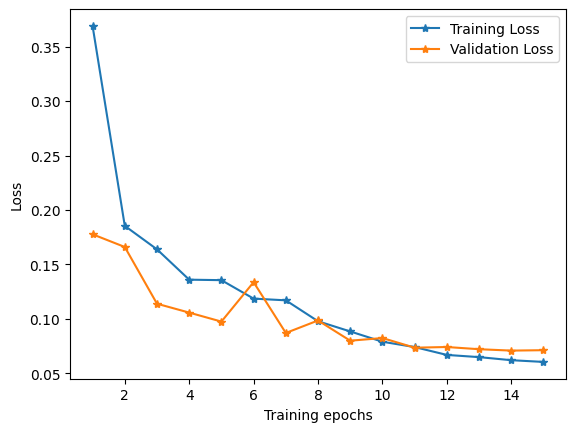

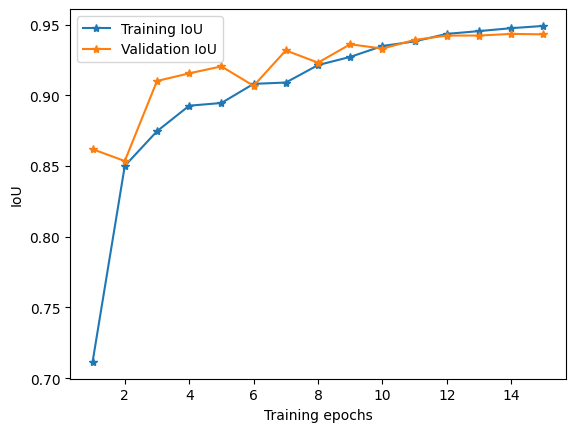

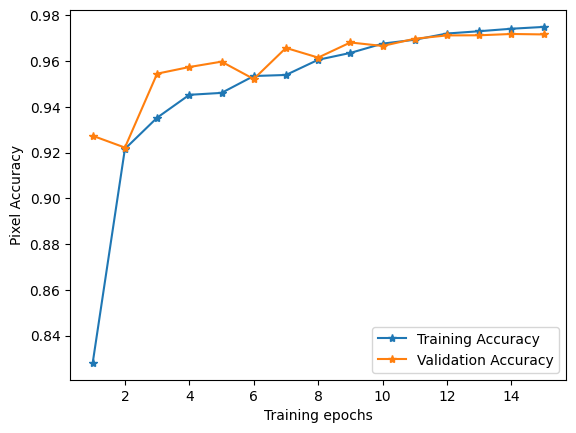

In [25]:
delete_title = True
delete_grid = True
plot_loss(history, delete_title=delete_title, delete_grid=delete_grid)
plot_score(history, delete_title=delete_title, delete_grid=delete_grid)
plot_acc(history, delete_title=delete_title, delete_grid=delete_grid)

## Load and Test Model

In [75]:
class WaterLaneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None, test_score=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.test_score = test_score

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X['id'][idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X['id'][idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
            mask = mask == 38
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        # テストデータ全体のスコアを見る際には, tensorにしておく
        if self.test_score is not None:
            mean=[0.485, 0.456, 0.406]
            std=[0.229, 0.224, 0.225]
            t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
            img = t(img)
        
        mask = torch.from_numpy(mask).long()
        
        
        return img, mask

In [76]:
STATE_DICT_PATH = '/Users/machidakentarou/GitHub/oyone_waterlane_detection/trained_models/iriomote_train_224_5d_12_17/Unet-Mobilenet_v2_mIoU-0.936.pt'

model = smp.Unet(
    'mobilenet_v2',
    encoder_weights='imagenet',
    classes=2, 
    activation=None,
    encoder_depth=5, 
    decoder_channels=[256, 128, 64, 32, 16]
    )
model.load_state_dict(torch.load(STATE_DICT_PATH))

<All keys matched successfully>

In [77]:
TEST_IMAGE_PATH = '/Users/machidakentarou/GitHub/oyone_waterlane_detection/samples/paper_sampls/JPEGImages/'
TEST_MASK_PATH = '/Users/machidakentarou/GitHub/oyone_waterlane_detection/samples/paper_sampls/SegmentationClassPNG/'
df_test = create_df(TEST_IMAGE_PATH)
t_test = A.Resize(HEIGHT,WIDTH, interpolation=cv2.INTER_NEAREST)
test_set = WaterLaneTestDataset(TEST_IMAGE_PATH, TEST_MASK_PATH, df_test, transform=t_test)
df_test

,id
0,converted_2022_9_3_16_54_00001960
1,converted_2022_9_3_16_54_00002160
2,converted_2022_9_3_16_54_00003700
3,converted_nigata_data6_frame_3
4,converted_2022_9_3_16_54_00003570
5,converted_2022_9_3_16_54_00002860
6,converted_nigata_data5_frame_514


In [27]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)  # 3D tensor -> 4D tensor
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [78]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)  # バッチ次元を削除
    return masked, acc


fps1.67


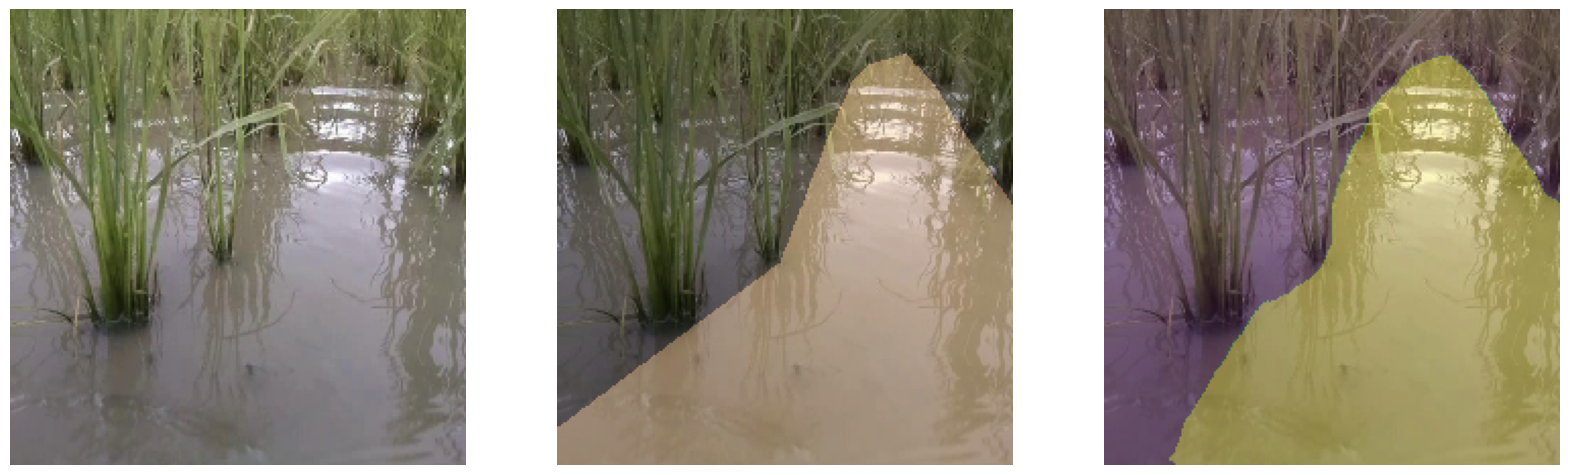

In [59]:
# Output with a Ground Truth image.
image, mask = test_set[2]
start = time.time()  # 計算時間
pred_mask, score = predict_image_mask_miou(model, image, mask)
end  = time.time()  # 計算時間
pred_mask, acc = predict_image_mask_pixel(model, image, mask)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
# ax1.set_title('Input')
ax1.set_axis_off()

ax2.imshow(image)
ax2.imshow(mask,cmap='copper', alpha=0.3)
# ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(image)
ax3.imshow(pred_mask, alpha=0.3)
# ax3.set_title('UNet-MobileNet | IoU {:.3f} | accuracy {:.3f}'.format(score, acc))
ax3.set_axis_off()
print('fps{}'.format(str(np.round(1/(end - start), 2))))

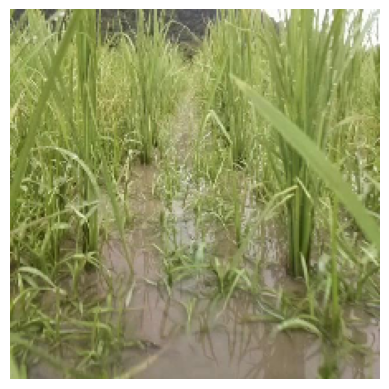

In [97]:
# セグメンテーション画像の出力のみ
# Output with a Ground Truth image.
image, mask = test_set[0]
start = time.time()  # 計算時間
pred_mask, score = predict_image_mask_miou(model, image, mask)
end  = time.time()  # 計算時間
pred_mask, acc = predict_image_mask_pixel(model, image, mask)
fig, ax = plt.subplots()
ax.imshow(image)
# ax.imshow(pred_mask, alpha=0.3)
ax.set_axis_off()

In [124]:
# テストセットの精度の計算を行う
t_test = A.Resize(HEIGHT,WIDTH, interpolation=cv2.INTER_NEAREST)
test_set = WaterLaneTestDataset(TEST_IMAGE_PATH, TEST_MASK_PATH, df_test, transform=t_test, test_score=True)
test_loader = DataLoader(test_set, batch_size=8)

running_acc = 0
running_loss = 0
running_score = 0
model.eval()
for image, mask in tqdm(test_loader):
    with torch.no_grad():
        model.to(device)
        image.to(device)
        mask.to(device)
        output = model(image)
        running_acc += pixel_accuracy(output, mask)
        running_score += mIoU(output, mask)
        loss = criterion(output, mask)
        running_loss += loss.item()

acc = running_acc/len(test_loader)
loss = running_loss/len(test_loader)
score = running_score/len(test_loader)

print('dataset: {}'.format(TEST_IMAGE_PATH))
print('the number of datasets: {}'.format(test_set.__len__()))
print("loss: {}".format(loss))
print("accuracy: {}".format(acc))
print("IoU: {}".format(score))

100%|██████████| 25/25 [00:17<00:00,  1.40it/s]

dataset: ../processed_data/voc_datasets/nigata_test_voc/JPEGImages/
the number of datasets: 197
loss: 0.13890546500682832
accuracy: 0.9433301578443879
IoU: 0.878248183384143


## Only image

In [273]:
class OnlyImageTestDataset(Dataset):
    def __init__(self, img_path, X, transform=None):
        self.img_path = img_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X['id'][idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        return img

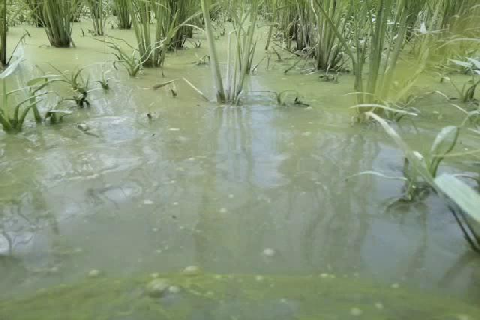

In [274]:
ONLY_IMAGE_PATH = '../samples/lane_example/'
df_test = create_df(ONLY_IMAGE_PATH)
t_test = A.Resize(HEIGHT,WIDTH, interpolation=cv2.INTER_NEAREST)
test_set = OnlyImageTestDataset(ONLY_IMAGE_PATH, df_test, transform=t_test)
test_set.__getitem__(0)

In [275]:
def predict_image_mask(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)  # 3D tensor -> 4D tensor
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

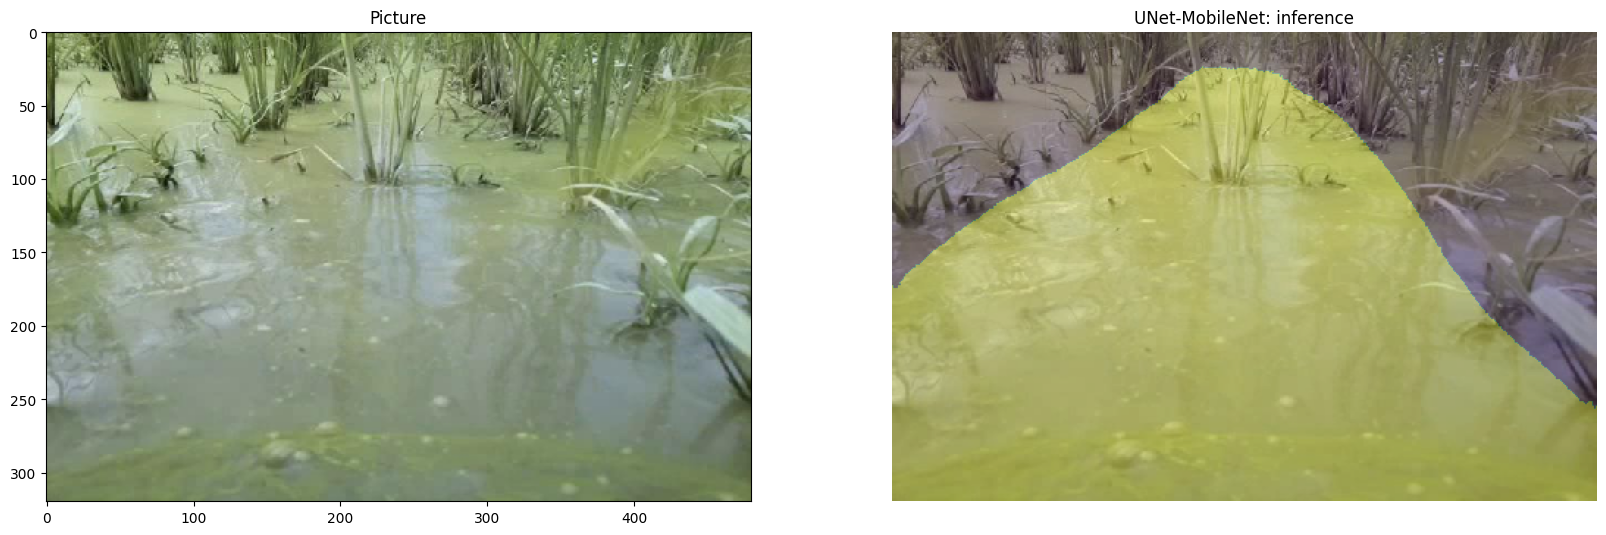

In [276]:
id = 0
image = test_set[id]
pred_mask = predict_image_mask(model, image)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(image)
ax2.imshow(pred_mask, alpha=0.3)
ax2.set_title('UNet-MobileNet: inference')
ax2.set_axis_off()